# Lab 2
Let's start with the same artificial data we used in Lab 1. Remember that we considered 2 models:
1. $M_1(x) = x+5$ 
2. $M_2(x) = 2x+1$


In [2]:
# Import the libraries we'll use below.
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def create_1d_data(num_examples=10, w=2, b=1, random_scale=1):
  """Create X, Y data with a linear relationship with added noise.

  Args:
    num_examples: number of examples to generate
    w: desired slope
    b: desired intercept
    random_scale: add uniform noise between -random_scale and +random_scale

  Returns:
    X and Y with shape (num_examples)
  """
  X = np.arange(num_examples)
  np.random.seed(4)  # consistent random number generation
  deltas = np.random.uniform(low=-random_scale, high=random_scale, size=X.shape)
  Y = b + deltas + w * X
  return X, Y

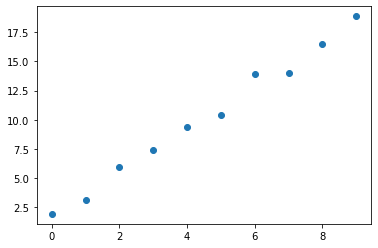

In [4]:
# Create some artificial data using create_1d_data.
X, Y = create_1d_data()
plt.scatter(X, Y)
plt.show()

## Notation
In our artificial data, things are pretty simple: each input example is just a single value. But soon, each input example will include multiple values or *features*, so we need some conventions to avoid confusion.

Let's start with the inputs:

\begin{align}
X =
\begin{pmatrix}
x^{(0)} \\
x^{(1)} \\
\vdots \\
x^{(m-1)}
\end{pmatrix}
\end{align}

* Capital $X$ refers to all input examples together.
* Lowercase $x$ refers to an individual input example; we use $x^{(i)}$ to refer to input example $i$; there are $m$ total examples.

Further, each input example $x$ could itself be a vector of feature values:

\begin{align}
x = [x_0, x_1, \dots x_{n-1}]
\end{align}

* Lowercase $x$ refers to all input features together for an individual input example.
* $x_i$ refers to feature $i$ for an input example $x$; there are $n$ total features.

Similarly, we can index labels $y^{(i)}$ in $Y$, which we can think of as a column vector where $y^{(i)}$ is the label for $x^{(i)}$.

\begin{align}
Y =
\begin{pmatrix}
y^{(0)} \\
y^{(1)} \\
\vdots \\
y^{(m-1)}
\end{pmatrix}
\end{align}

In general, we're using matrix notation. Rows refer to examples and columns refer to features. If we want to be very specific and refer to a particular feature of a particular input example, we can use $x_{i,j}$ for input $i$, feature $j$. Using matrices will be useful for coding ML algorithms since most of the operations we will do can be expressed as operations on matrices.


##Parameter Vectors
Let's prepare to learn a linear model $h(x)$ that approximates values of $Y$ from corresponding values of $X$. Since our input data has only one feature, our model will have two parameters (also called weights), which we'll refer to collectively as $W$:

\begin{align}
h(x) = w_0 + w_1x
\end{align}

Notice that if we prepend an extra feature (column) to $X$ that is always $1$, we can rewrite our model using a matrix multiplication:

\begin{align}
h(x) = w_0x_0 + w_1x_1 = xW^T
\end{align}

To make this matrix formulation as clear as possible, this is:

\begin{align}
\hat{y} = xW^T =
\begin{pmatrix}
x_0 & x_1 \\
\end{pmatrix}
\begin{pmatrix}
w_0 \\
w_1 \\
\end{pmatrix}
\end{align}

In addition, if we wanted to apply our model to *all* inputs $X$, we could simply use $XW^T$:

\begin{align}
\hat{Y} = XW^T =
\begin{pmatrix}
x_{0,0} & x_{0,1} \\
x_{1,0} & x_{1,1} \\
\vdots & \vdots \\
x_{m-1,0} & x_{m-1,1} \\
\end{pmatrix}
\begin{pmatrix}
w_0 \\
w_1 \\
\end{pmatrix}
\end{align}

Remember that [matrix multiplication](https://en.wikipedia.org/wiki/Matrix_multiplication) requires the inner dimensions to line up: 

\begin{align}
X_{\{m \times n\}} W^T_{\{n \times 1 \}}  = \hat{Y}_{\{m \times 1 \}}
\end{align}

### Exercise 1: Practice with Parameters
Add a column of 1s to $X$. Then, use matrix multiplication (np.dot) to apply $M_1$ and $M_2$ (from above) to produce vectors of predictions. Print the shapes of the predictions to validate that they have the same shape as $Y$.

#### Student Solution

In [5]:
# Add a column of 1s to X by using np.c_ to concatenate with the current values.
X_with_1s = np.c_[np.ones(X.shape[0]), X]

# YOUR CODE HERE
W_1 = np.matrix([5,1])
W_2 = np.matrix([1,2])
Y_hat_1 = np.asmatrix(X_with_1s) * np.transpose(W_1)
Y_hat_2 = np.asmatrix(X_with_1s) * np.transpose(W_2)

print("Dimensions of X:",np.shape(X_with_1s))
print("\nDimensions of Y_hat_1:",np.shape(Y_hat_1))
print("\nDimensions of Y_hat_2:",np.shape(Y_hat_2))
print("\nDimensions of Y:",np.shape(np.transpose(np.asmatrix(Y))))

Dimensions of X: (10, 2)

Dimensions of Y_hat_1: (10, 1)

Dimensions of Y_hat_2: (10, 1)

Dimensions of Y: (10, 1)


## Gradient Descent
Here we'll demonstrate gradient descent for linear regression to learn the weight vector $W$. We'll use the more specific notation $h_W(x)$ since we want to specify that $h$ is parameterized by $W$. As above, we'll assume that $x_0=1$ so we can write $h$ as a sum or a matrix product:

\begin{align}
h_W(x) = \sum_{i=0}^{n-1} w_i x_i = x W^T
\end{align}

In the derivation that follows, we'll use summations, but in the code below, we'll use matrix computations.

In linear regression, we compute the loss, $J(W)$ from the mean squared difference between predictions $h_W(x)$ and targets $y$. In the following equation, we average the loss over each of the $m$ training examples.

\begin{align}
J(W) = \frac{1}{2m} \sum_{i=0}^{m-1} (h_W(x^{(i)}) - y^{(i)})^2
\end{align}

Dividing by $2$ simplifies the formula of the gradient, since it cancels out the constant $2$ from by the derivative of the squared term (see below). Remember that the gradient is a vector of partial derivatives for each $w_j$ (holding the other elements of $w$ constant). The gradient points in direction of steepest ascent for the loss function $J$.

Here we derive the parameter update rule by computing the gradient of the loss function. We need a derivative for each feature in $x$, so we'll show how to compute the derivative with respect to $w_j$. For simplicity, let's assume we have only one training example ($m = 1$):

\begin{align}
\frac{\partial}{\partial w_j} J(W) &= \frac{\partial}{\partial w_j} \frac{1}{2} (h_W(x) - y)^2 \tag{1}\\
&= 2 \cdot \frac{1}{2} (h_W(x) - y) \cdot \frac{\partial}{\partial w_j} (h_W(x) - y) \tag{2}\\
&= (h_W(x) - y) \frac{\partial}{\partial w_j} \left(\sum_{i=0}^{n-1} w_i x_i - y \right) \tag{3}\\
&= (h_W(x) - y)x_j \tag{4}
\end{align}

The derivation has 2 key steps:

(1) Apply the [chain rule](https://en.wikipedia.org/wiki/Chain_rule) (step 1 -> 2).

(2) The derivative with respect to $w_j$ of $h_W(x)$ is only non-zero for $w_j x_j$. For this component, the derivative is $x_j$ since the feature value is treated as a constant (step 3 -> 4).

Ok, that's it. We can now implement gradient descent for linear regression. The only difference in the code below is that it computes the loss as an average over all training examples (rather than just a single example).

### Exercise 2: Implementing Gradient Descent for Linear Regression
Fill in the `NotImplemented` parts of the gradient descent function below. There are detailed comments to help guide you. Note that this function uses vectors and matrices so you'll want to use numpy functions like `np.dot` to multiply them, for example.

##### Student Solution

In [6]:
def gradient_descent(inputs, outputs, learning_rate, num_epochs):
  """Apply the gradient descent algorithm to learn learn linear regression.

  Args:
    inputs: A 2-D array where each column is an input feature and each
            row is a training example.
    outputs: A 1-D array containing the real-valued
             label corresponding to the input data in the same row.
    learning_rate: The learning rate to use for updates.
    num_epochs: The number of passes through the full training data.

  Returns:
    weights: A 2-D array with the learned weights after each training epoch.
    losses: A 1-D array with the loss after each epoch.
  """
  # m = number of examples, n = number of features
  m, n = inputs.shape
  
  # We'll use a vector of size n to store the learned weights and initialize
  # all weights to 1. 
  W = np.ones(n)
  
  # Keep track of the training loss and weights after each step.
  losses = []
  weights = []
  
  for epoch in range(num_epochs):
    # Append the old weights to the weights list to keep track of them.
    weights.append(W)

    # Evaluate the current predictions for the training examples given
    # the current estimate of W (you did this in exercise 1). 
    predictions = np.dot(inputs,np.transpose(np.asmatrix(W))) 
    
    # Find the difference between the predictions and the actual target
    # values.
    diff = predictions - np.transpose(np.asmatrix(outputs))
    
    # In standard linear regression, we want to minimize the sum of squared
    # differences. Compute the mean squared error loss. Don't bother with the
    # 1/2 scaling factor here.
    loss = np.sum(np.square(diff))/m

    # Append the loss to the losses list to keep a track of it.
    losses.append(loss)
    
    # Compute the gradient with respect to the loss.
    # [Formula (4) in the Gradient Descent Implementation]
    gradient = np.ravel(np.dot(np.transpose(np.asmatrix(inputs)),diff)/m)

    # Update weights, scaling the gradient by the learning rate.
    W = W - learning_rate * gradient
      
  return np.array(weights), np.array(losses)

Let's try running gradient descent with our artificial data and print out the results. Note that we're passing the version of the input data with a column of $1s$ so that we learn an *intercept* (also called a *bias*). We can also try learning without the intercept.

Note: if your implementation of gradient descent is correct, you should get a loss of ~0.409 after 5 epochs (with a bias parameter).

In [7]:
print('Running gradient descent...')
weights, losses = gradient_descent(X_with_1s, Y, learning_rate=.02,
                                   num_epochs=5)
for W, loss in zip(weights, losses):
  print(loss, W)

print('\nRunning gradient descent without biases...')
# Make sure we're providing an input with the right 2-D shape.
X_without_1s = np.expand_dims(X, axis=0).T
weights_without_bias, losses_without_bias = gradient_descent(X_without_1s, Y,
                                                             .02, num_epochs=5)
for W, loss in zip(weights_without_bias, losses_without_bias):
  print(loss, W)

Running gradient descent...
28.096877896274293 [1. 1.]
5.175011571046788 [1.09314344 1.56138661]
1.2139312663315942 [1.13389921 1.79439995]
0.5285784110759881 [1.15286867 1.89092766]
0.40916048838830177 [1.16277124 1.93072732]

Running gradient descent without biases...
38.4112216429843 [1.]
8.073448610301934 [1.65138661]
2.4639943765589676 [1.93148285]
1.426806288739892 [2.05192424]
1.235030211302147 [2.10371403]


### Exercise 3: Interpreting the Model
Write down the learned model with and without an intercept term. Which model fits the data better?

#### Student Solution

Model with intercept:  
$M_{01}(x) = 1.931x+1.163$ 

Model without intercept:  

$M_{02}(x) = 2.104x$

With a loss of ~0.409, the first model with intercept fits the data better than the second model with a loss of ~1.23.

## Gradient Descent Progress
Let's write a function that lets us visualize the progress of gradient descent during training. Our gradient descent function already provides intermediate weight vectors and losses after each epoch, so we just need to plot these.

In [8]:
def plot_learning(inputs, outputs, weights, losses):
  """Plot predictions and losses after each training epoch.

  Args:
    inputs: A 2-D array where each column is an input feature and each
            row is a training example.
    outputs: A 1-D array containing the real-valued
             label corresponding to the input data in the same row.
    weights: A 2-D array with the learned weights after each training epoch.
    losses: A 1-D array with the loss after each epoch.
  """
  # Create a figure.
  plt.figure(1, figsize=[10,4])

  # The first subplot will contain the predictions. Start by plotting the
  # outputs (Y).
  plt.subplot(121)
  plt.xlabel('x')
  plt.ylabel('y')
  plt.xticks(inputs[:,1])
  plt.scatter(inputs[:,1], outputs, color='black', label='Y')
  
  # For each epoch, retrieve the estimated weights W, compute predictions, and
  # plot the resulting line.
  num_epochs = len(weights)
  for i in range(num_epochs):
    W = weights[i]
    predictions = np.dot(inputs, W.T)
    plt.plot(inputs[:,1], predictions, label='Epoch %d' %i)
  plt.legend()

  # The second subplot will contain the losses.
  plt.subplot(122)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.xticks(range(num_epochs))
  plt.plot(range(num_epochs), losses, marker='o', color='black',
           linestyle='dashed')
  plt.show()

### Exercise 4: Plotting Progress

Re-run gradient descent using X_with_1s, but this time with learning_rate=0.01 and num_epochs=7.

Run the plot_learning function using the weights and losses returned by gradient_descent (from above) and answer the following questions:

1. Is learning converging faster or slower than when we used learning_rate=0.02?
2. If you continue training, will the loss eventually reach 0?
3. If you continue training, will the model eventually converge to $h(x)=2x+1$?

#### Student Solution

Running gradient descent...
28.096877896274293 [1. 1.]
14.270645620677294 [1.04657172 1.28069331]
7.343191347047517 [1.08004652 1.47929329]
3.8721252845709295 [1.10424958 1.61978592]
2.1327609079282 [1.12188843 1.71914901]
1.2610055930000243 [1.13487956 1.78939986]
0.8239365677061619 [1.14457949 1.83904463]


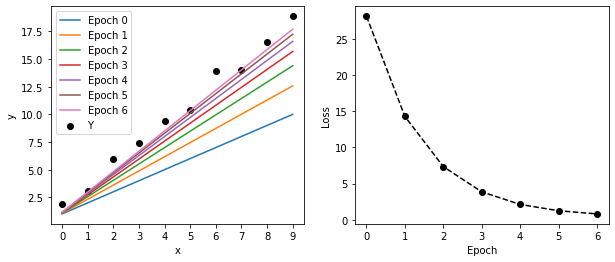

In [16]:
print('Running gradient descent...')
weights, losses = gradient_descent(X_with_1s, Y, learning_rate=.01,
                                   num_epochs=7)
for W, loss in zip(weights, losses):
  print(loss, W)
plot_learning(X_with_1s, Y, weights, losses)

WRITE YOUR ANSWERS HERE

1. The learning converging is slower when learning_rate=0.01 than learning_rate=0.02.
2. No. The loss will not reach exact 0 since the data is not perfectly linear and the converging rate is slowing down. 
3. No. The model will not eventually converge to $h(x)=2x+1$.

## Review
* We store our data in arrays where **each row is an input example** $x^{(i)}$ and **each column is a feature**. Training example $x^{(i)}$ corresponds to training label $y^{(i)}$.
* **Gradient descent** is an **optimization process** that **minimizes loss** $J(W)$ where $W$ is a set of parameters (or weights). The loss measures the difference between  predictions $\hat{Y}$ using the current values of $W$ and the target labels $Y$, and gradient descent updates $W$ by taking a **step in the direction of the loss gradient**.
* Each pass over the training data by the gradient descent algorithm is called an **epoch**. The algorithm has no specific stopping point, but we often choose to stop when the parameter values have **converged**, that is, the change in values in the next step are less than some small $\epsilon$.